# AIPI 590 - XAI | Assignment #2
### Machine Learning Court
### Anish Parmar


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anishParmar9778/DukeXAI/blob/main/HW2/AIPI_590_MLcourt.ipynb)

⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset

🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

🟦 Defense

Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

The following code below is directly taken from the machine_learning_court.ipynb from the class repository.

https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb

In [1]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [2]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")

Prediction for Jane Dow (Loan Eligibility): Denied


**Exploring the Dataset**

In [3]:
print("Class Distribution:")
print(y.value_counts())
print("\nTrain/Test Split Distribution:")
print(y_train.value_counts())
print(y_test.value_counts())


Class Distribution:
class
0    45222
Name: count, dtype: int64

Train/Test Split Distribution:
class
0    36177
Name: count, dtype: int64
class
0    9045
Name: count, dtype: int64


Above we can see that the data is not distributed well. It only contains class 0 (less than 50K). The train and test splits also contain only class 0. This explains why the precision, recall and other scores are all 1. This is not how models are to be trained as it will classify every case as class 0 (never seen class 1 in training before).

# **SHAP**

Each of the following methods contains an XAI method used to explain the focus instance. Each method section has a brief explanation and analysis of the results.

All of the code below is either directly taken or derived from the local_explanations.ipynb from the class Github Repository.

https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb#scrollTo=zS19oKUE780n

In [4]:
import shap

# Compute SHAP values

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model_adult, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

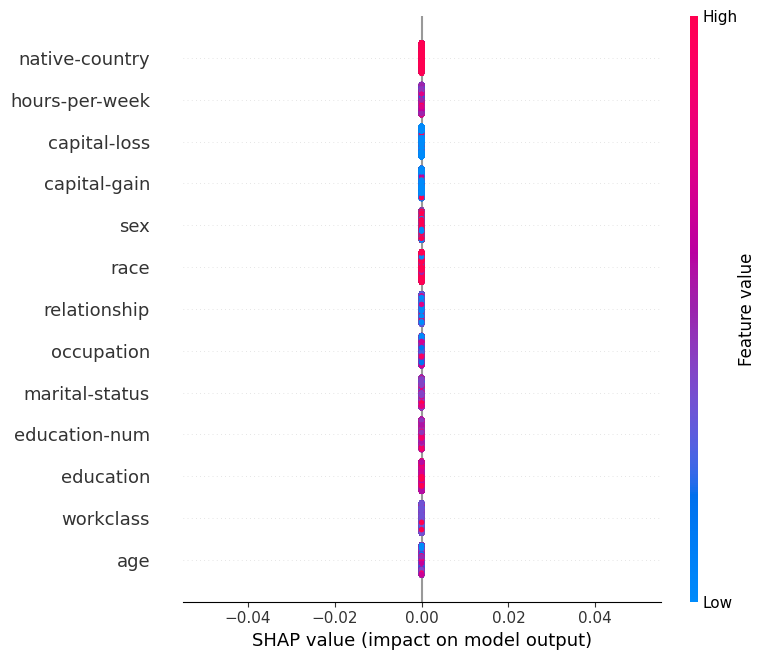

In [5]:
# Visualize SHAP with Summary Plot
shap.summary_plot(shap_values, X_test)

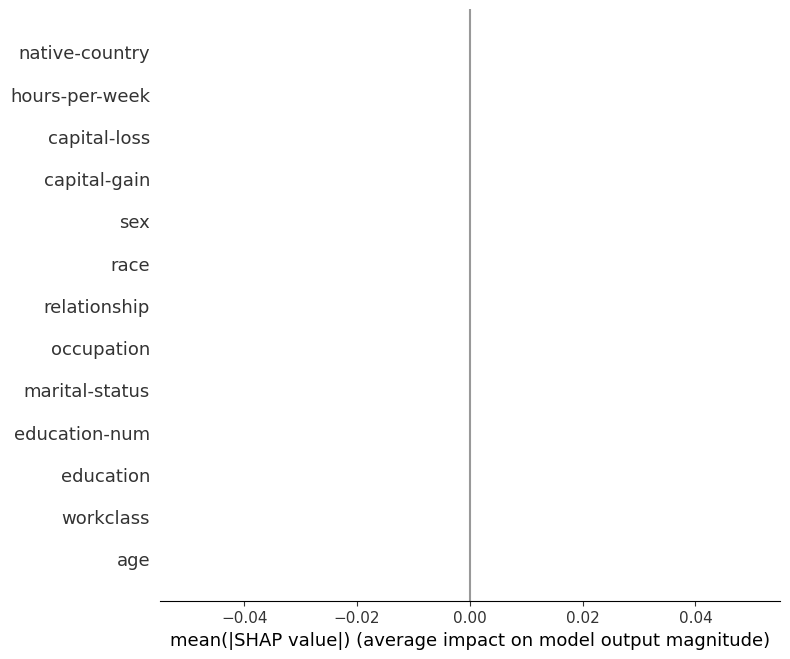

In [6]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

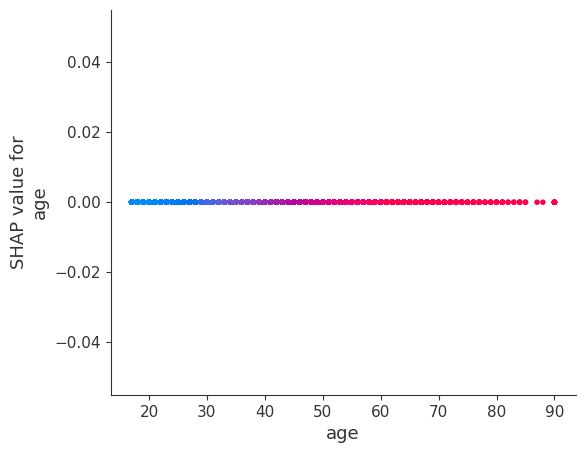

In [7]:
# Visualize SHAP with Dependence Plot
shap.dependence_plot('age', shap_values, X_test)

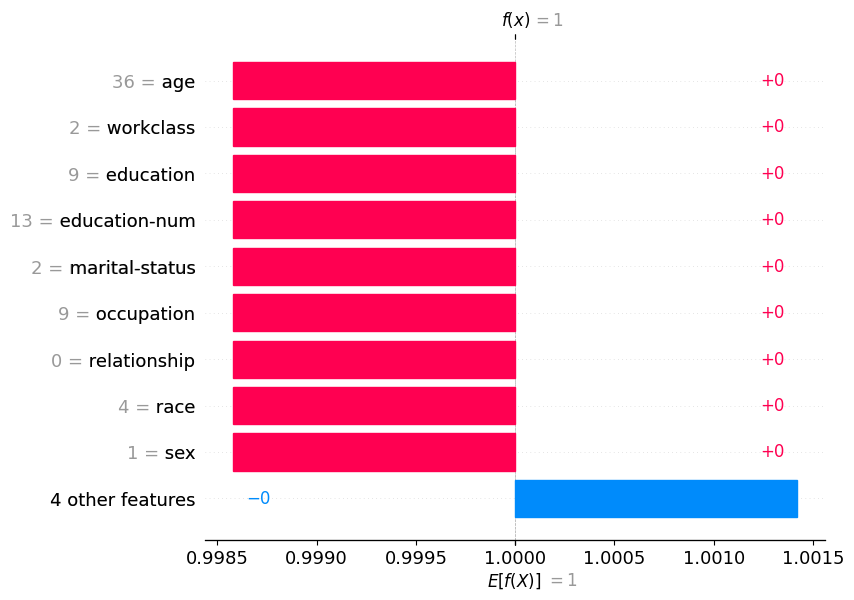

In [8]:
# Visualize an instance with a waterfall plot of the SHAP values

# Choose a sample for explanation
idx = 100

# Plot waterfall plot
shap.plots.waterfall(shap_values_exp[idx])

**Explanation & Analysis**

SHAP (SHapley Additive exPlanations) is a method from coalitional game theory that assigns a value of importance to each feature for a specific prediction. It tells us how much each feature contributed to the difference between the model's prediction and the model's average prediction.

The SHAP summary plot shows all features having a value of 0, which implies that none of the features are having a substantial impact on the model's predictions.

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. However, here we can see with the age feature all SHAP values are 0, suggesting that the model is not using age at all to inform its prediction (this is the same with all other features).

The waterfall plot displays SHAP values for an instance of interest. We can see in the waterfall plot all features have either +0 or -0, indicating the features did not influence the prediction at all.

The plots above indicate that SHAP values are 0 for all features and instances. This is happening since the model classifies all applicants in class 0 (<50K denial). This means that no particular feature influenced the prediction differently than any other feature.

# **LIME**

In [16]:
feature_names = list(X_train.columns)

# Fix categorical features: these are indices, not strings
categorical_features = [
    feature_names.index('workclass'),
    feature_names.index('education'),
    feature_names.index('marital-status'),
    feature_names.index('occupation'),
    feature_names.index('relationship'),
    feature_names.index('race'),
    feature_names.index('sex'),
    feature_names.index('native-country')
]

class_names = ['<=50K', '>50K']

categorical_names = {
    1: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],  # Workclass
    3: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],  # Marital Status
    4: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],  # Occupation
    5: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],  # Relationship
    6: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],  # Race
    7: ['Female', 'Male'],  # Sex
    11: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']  # Country
}

In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fdc7bdccc3be855aef059200d47bf8389918b3818ad12811b720dd32fd82fc7f
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [18]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,class_names=class_names, feature_names=feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=kernel_width)
# Choose a sample for explanation
idx = 0

# Explain the prediction using LIME
exp = explainer.explain_instance(X_test.values[idx], model_adult.predict_proba, num_features=12)

# Show the explanation
exp.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

In [19]:
print(model_adult.predict_proba(X_test[:5]))
print(model_adult.classes_)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[0]


**Explanation & Analysis**

LIME (local interpretable model-agnostic explanations) explains individual predictions of a black-box model.

The code for LIME does not run and gets the error "IndexError: index 1 is out of bounds for axis 1 with size 1". This is because LIME expects 2 classes with predict_proba. However, the model only outputs one probability column ([[1.][1.][1.][1.][1.]]) with class = 0.

Since the model only predicts one class, LIME cannot be used to create useful local explanations (no difference to see between class 0 and 1).

# **Anchors**

In [27]:
!pip uninstall -y anchor

Found existing installation: anchor 0.4.0
Uninstalling anchor-0.4.0:
  Successfully uninstalled anchor-0.4.0


In [28]:
!pip install anchor-exp==0.0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for anchor-exp: filename=anchor_exp-0.0.2.0-py3-none-any.whl size=433502 sha256=7cc1bdf3a670e25274958cada4eeb98b9fcbab7b1aa3fdf090248cd538072183
  Stored in directory: /root/.cache/pip/wheels/9b/5f/6b/cac283c098eb5a7512f69953e7b5ced94b17e4f8591401b978
Successfully built anchor-exp


In [29]:
from anchor import anchor_tabular

# Initialize Anchors explainer
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values,
    categorical_names)

In [31]:
# Choose a sample for explanation
idx = 100

# Print Prediction
print('Prediction: ', explainer.class_names[model_adult.predict(X_test.values[idx].reshape(1, -1))[0]])

Prediction:  <=50K


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [33]:
# Explain the prediction using Anchors
exp = explainer.explain_instance(X_test.values[idx], model_adult.predict, threshold=0.80)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [34]:
# Print the prediction, precision, and coverage
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: 
Precision: 1.00
Coverage: 1.00


**Explanations & Analysis**

The Anchors method tries to find decision rule explanations for predictions. Above the print results show an empty anchor with 100% precision and 100% coverage. This implies that no specific features were needed to explain the prediction. This is because the model outputs the same class for every instance in the dataset (as we have observed from other techniques above).

# **ICE Plots**

In [36]:
from sklearn.inspection import PartialDependenceDisplay

# Choose the feature of interest
features = ["age"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model_adult, X_test, features, kind='individual') #kind='individual'

ValueError: Got predict_proba of shape (9045, 1), but need classifier with two classes.

In [38]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top

PartialDependenceDisplay.from_estimator(model_adult, X_test, features, kind='both') #kind='both'

ValueError: Got predict_proba of shape (9045, 1), but need classifier with two classes.

In [40]:
PartialDependenceDisplay.from_estimator(model_adult, X_test, features, kind='both', centered=True)

ValueError: Got predict_proba of shape (9045, 1), but need classifier with two classes.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 0  # Choose the index of the instance you want to visualize
feature_index = 0  # Let's look at "Age"

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = model_adult.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

**Explanation & Analysis**

Individual Conditional Expectation (ICE) plots one line per instance that displays how the instance’s prediction changes when a feature changes.

However we can see that above all of the ICE plot related code does not run. This is because ICE expects a binary or multiclass model with at least two probability columns. We saw earlier with LIME that predict_proba only outputs one probability column since the model predicts only class 0 for all instances.

Since the model never predicts more than one class, ICE plots cannot show any variation in predicted probabilities. Regardless of the feature, every curve would just be flat at 1.0 for class 0. Ultimately, this suggests that the model is not differentiating the applicants based on any feature (all are processed the same).

# **Defense**

Based on the model's learned relationships and the explainability analysis shown above, I would argue that Jane Dow's denial is infact not a result of unfair or discriminatory practices.

We can observe that the model consistently assigns denial for all applicants in the adult dataset since the training data only contains instances of class 0 (less than 50K). SHAP, LIME, Anchors and ICE analyses all show that no individual feature (age, gender, etc.) contributed unequally to Jane's denial. All features displayed either zero or flat contributions, meaning the model used the same logic across all features.

This means that Jane was not discriminated based on her age, gender, education, or any other attribute. Jane being denied is something that all applicants would encounter regardless of their individual backgrounds. The current iteration of the provided model is clearly limited by a lack of class 1 (greater than 50K) instances in the training and test sets (dataset imbalance). However, it's decision-making process is non-discriminatory, transparent and consistent across all users.

In conclusion, Jane’s denial was not the product of unfair reasoning but instead due to a model that treats all applicants identically. Retraining the model with a balanced dataset would be necessary to improve classification accuracy without compromising fairness.